In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
!git pull

Already up to date.


In [60]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from zoobot.active_learning import check_uncertainty, metrics, acquisition_utils

In [ ]:
### Make predictions on DECALS (will be script?)

In [2]:
LOCAL = True

In [5]:
# QUESTION = 'bars'
QUESTION = 'smooth'

# NEW_PREDICTIONS = False
NEW_PREDICTIONS = True

### Get data on which to make predictions (only needed if local)

In [ ]:
assert LOCAL

Shards live at /root/repos/zoobot/data/decals/shards/decals_smooth_may/eval_shards/s256_shard_{n}.tfrecord. These are never acquired, and reserved for testing. Also includes catalog eval_df.csv.

From AWS: aws s3 sync eval_shards s3://galaxy-zoo/active-learning/decals_smooth_may_eval_shards
From local: 

In [ ]:
!aws s3 sync s3://galaxy-zoo/active-learning/decals_smooth_may_eval_shards decals_smooth_may_eval_shards

### Get a model (only needed if local)

On AWS: aws s3 sync ~/root/repos/zoobot/data/experiments/decals_smooth_may/iteration_6/estimators s3://galaxy-zoo/active-learning/decals_smooth_may_iteration_6_estimators

Locally (better in terminal): aws s3 sync s3://galaxy-zoo/active-learning/decals_smooth_may_iteration_6_estimators decals_smooth_may_iteration_6_estimators 

In [20]:
results_dir = 'estimators/decals_smooth_may_iteration_6_estimators'
model_name = '1566573780'

## Make predictions

In [99]:
tfrecord_dir = 'decals_smooth_may_eval_shards'
tfrecord_loc = [os.path.join(tfrecord_dir, x) for x in os.listdir(tfrecord_dir) if x.endswith('.tfrecord')]

n_samples = 30
n_galaxies = 5000

save_dir = 'predictions/{}'.format(model_name)

In [100]:
if QUESTION == 'smooth':
    EXPECTED_VOTES = 40
elif QUESTION == 'bars':
    EXPECTED_VOTES = 10

In [101]:
images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc,
    n_galaxies,
    results_dir,
    model_name,
    inital_size=256,
    n_samples=n_samples
)
assert samples.shape[1] == n_samples

INFO:tensorflow:Restoring parameters from estimators/decals_smooth_may_iteration_6_estimators/1566573780/variables/variables


INFO:tensorflow:Restoring parameters from estimators/decals_smooth_may_iteration_6_estimators/1566573780/variables/variables


In [102]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
acquisitions = acquisition_utils.mutual_info_acquisition_func(samples, expected_votes=EXPECTED_VOTES)
# metrics.save_iteration_state(save_dir, subjects, samples, acquisitions=acquisitions)

In [103]:
eval_df = pd.read_csv('decals_smooth_may_eval_shards/eval_df.csv')

In [104]:
eval_df['iauname']

0       J151023.19+020737.5
1       J015708.34+122855.0
2       J091427.67+073429.7
3       J141021.96+020037.9
4       J025835.45-075405.0
               ...         
4995    J020609.10+000137.0
4996    J132649.77+010307.4
4997    J105847.32+103337.9
4998    J101018.04+023719.1
4999    J102333.96+060249.7
Name: iauname, Length: 5000, dtype: object

In [105]:
prediction_data = [{'iauname': id_strs[n].decode('utf-8'), 'predictions': samples[n][:]} for n in range(len(id_strs))]

In [106]:
predictions = pd.DataFrame(data=prediction_data)

In [107]:
predictions = pd.merge(predictions, eval_df, how='inner', on='iauname')

In [108]:
predictions['median_prediction'] = predictions['predictions'].apply(lambda x: np.median(x))

In [109]:
predictions.columns.values

array(['iauname', 'predictions', 'Unnamed: 0', 'index', 'nsa_id', 'ra',
       'dec', 'petrotheta', 'petroth50', 'petroth90', 'redshift',
       'local_fits_loc', 'local_png_loc', 'fits_ready', 'fits_filled',
       'png_ready', 'nsa_version', 'file_loc', 'subject_id',
       'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'smooth-or-featured_smooth',
       'how-rounded_round', 'how-rounded_in-between',
       'how-rounded_cigar-shaped', 'disk-edge-on_yes', 'disk-edge-on_no',
       'edge-on-bulge_rounded', 'edge-on-bulge_boxy',
       'edge-on-bulge_none', 'bar_strong', 'bar_weak', 'bar_no',
       'has-spiral-arms_yes', 'has-spiral-arms_no',
       'spiral-winding_tight', 'spiral-winding_medium',
       'spiral-winding_loose', 'spiral-arm-count_1', 'spiral-arm-count_2',
       'spiral-arm-count_3', 'spiral-arm-count_4',
       'spiral-arm-count_more-than-4', 'spiral-arm-count_cant-tell',
       'bulge-size_none', 'bulge-size_small', 'bulge-size_moderate'

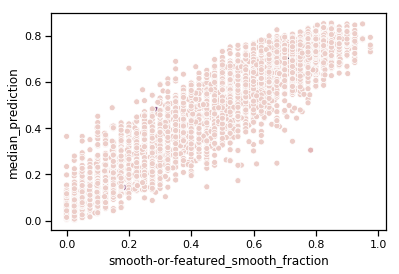

In [110]:
sns.scatterplot(data=predictions, x='smooth-or-featured_smooth_fraction', y='median_prediction', hue='smooth-or-featured_total-votes', legend=False)

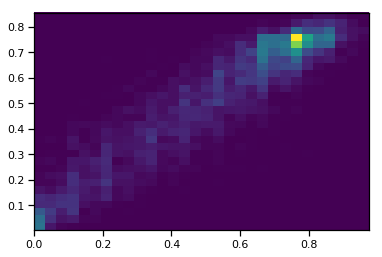

In [115]:
_ = plt.hist2d(predictions['smooth-or-featured_smooth_fraction'], predictions['median_prediction'], bins=[30, 30])

In [111]:
len(eval_df)

5000

In [112]:
predictions.to_parquet('decals_may_test_set_predictions.parquet')